<a href="https://colab.research.google.com/github/run-llama/llama_index/blob/main/docs/docs/examples/evaluation/UpTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to use UpTrain with LlamaIndex

**Overview**: In this example, we will see how to use UpTrain with LlamaIndex. UpTrain ([github](https://github.com/uptrain-ai/uptrain) || [website](https://github.com/uptrain-ai/uptrain/) || [docs](https://docs.uptrain.ai/)) is an open-source platform to evaluate and improve GenAI applications. It provides grades for 20+ preconfigured checks (covering language, code, embedding use cases), performs root cause analysis on failure cases and gives insights on how to resolve them. More details on UpTrain's evaluations can be found [here](https://github.com/uptrain-ai/uptrain?tab=readme-ov-file#pre-built-evaluations-we-offer-).


**Problem**: There are two main problems:
1. The data that most Large Language Models are trained on is not representative of the data that they are used on. This leads to a mismatch between the training and test distributions, which can lead to poor performance. 
2. The results generated by Large Language Models are not always reliable. The responses might not be relevant to the prompt, not align with the desired tone or the context, or might be offensive etc.

**Solution**: The above two problems are solved by two different tools and we will show you how to use them together:
1. LlamaIndex solves the first problem by allowing you to perform Retrieval Augmented Generation (RAG) with a retriever that is fine-tuned on your own data. This allows you to use your own data to fine-tune a retriever, and then use that retriever to perform RAG.
2. UpTrain solves the second problem by allowing you to perform evaluations on the generated responses. This helps you to ensure that the responses are relevant to the prompt, align with the desired tone or the context, and are not offensive etc.

## Install UpTrain and LlamaIndex

In [ ]:
%pip install -qU uptrain llama-index

Note: you may need to restart the kernel to use updated packages.


## Import required libraries

In [ ]:
import httpx
import os
import openai
import pandas as pd

from llama_index.core import VectorStoreIndex, SimpleDirectoryReader, Settings
from uptrain import Evals, EvalLlamaIndex, Settings as UpTrainSettings

/Users/dhruvchawla/Work/llama_index/venv/lib/python3.11/site-packages/lazy_loader/__init__.py:185: RuntimeWarning: subpackages can technically be lazily loaded, but it causes the package to be eagerly loaded even if it is already lazily loaded.So, you probably shouldn't use subpackages with this lazy feature.
  warnings.warn(msg, RuntimeWarning)


## Create the dataset folder for the query engine

You can use any documents that you have to do this. For this tutorial, we will use data on New York City extracted from wikipedia. We will only add one document to the folder, but you can add as many as you want.

In [ ]:
url = "https://uptrain-assets.s3.ap-south-1.amazonaws.com/data/nyc_text.txt"
if not os.path.exists("nyc_wikipedia"):
    os.makedirs("nyc_wikipedia")
dataset_path = os.path.join("./nyc_wikipedia", "nyc_text.txt")

if not os.path.exists(dataset_path):
    r = httpx.get(url)
    with open(dataset_path, "wb") as f:
        f.write(r.content)

## Make the list of queries

Before we can generate responses, we need to create a list of queries. Since the query engine is trained on New York City, we will create a list of queries related to New York City.

In [ ]:
data = [
    {"question": "What is the population of New York City?"},
    {"question": "What is the area of New York City?"},
    {"question": "What is the largest borough in New York City?"},
    {"question": "What is the average temperature in New York City?"},
    {"question": "What is the main airport in New York City?"},
    {"question": "What is the famous landmark in New York City?"},
    {"question": "What is the official language of New York City?"},
    {"question": "What is the currency used in New York City?"},
    {"question": "What is the time zone of New York City?"},
    {"question": "What is the famous sports team in New York City?"},
]

**This notebook uses the OpenAI API to generate text for prompts as well as to create the Vector Store Index. So, set openai.api_key to your OpenAI API key.**

In [ ]:
openai.api_key = "sk-************************"  # your OpenAI API key

## Create a query engine using LlamaIndex

Let's create a vector store index using LLamaIndex and then use that as a query engine to retrieve relevant sections from the documentation.

In [ ]:
Settings.chunk_size = 512

documents = SimpleDirectoryReader("./nyc_wikipedia/").load_data()

vector_index = VectorStoreIndex.from_documents(
    documents,
)

query_engine = vector_index.as_query_engine()

## Setup

UpTrain provides you with:
1. Dashboards with advanced drill-down and filtering options
1. Insights and common topics among failing cases
1. Observability and real-time monitoring of production data
1. Regression testing via seamless integration with your CI/CD pipelines

You can choose between the following two alternatives for evaluating using UpTrain:

# Alternative 1: Evaluate using UpTrain's Open-Source Software (OSS)

You can use the open-source evaluation service to evaluate your model. In this case, you will need to provide an OpenAI API key. You can get yours [here](https://platform.openai.com/account/api-keys).

In order to view your evaluations in the UpTrain dashboard, you will need to set it up by running the following commands in your terminal:

```bash
git clone https://github.com/uptrain-ai/uptrain
cd uptrain
bash run_uptrain.sh
```

This will start the UpTrain dashboard on your local machine. You can access it at `http://localhost:3000/dashboard`.

**Note:** The `project_name` will be the project name under which the evaluations performed will be shown in the UpTrain dashboard.

In [ ]:
settings = UpTrainSettings(
    openai_api_key=openai.api_key,
)

## Create the EvalLlamaIndex object

Now that we have created the query engine, we can use it to create an EvalLlamaIndex object. This object will be used to generate responses for the queries.

In [ ]:
llamaindex_object = EvalLlamaIndex(
    settings=settings, query_engine=query_engine
)

## Run the evaluation

Now that we have the list of queries, we can use the EvalLlamaIndex object to generate responses for the queries and then perform evaluations on the responses. You can find an extensive list of the evaluations offered by UpTrain [here](https://docs.uptrain.ai/key-components/evals). We have chosen two that we found to be the most relevant for this tutorial:

1. **Context Relevance**: This evaluation checks whether the retrieved context is relevant to the query. This is important because the retrieved context is used to generate the response. If the retrieved context is not relevant to the query, then the response will not be relevant to the query either.

2. **Response Conciseness**: This evaluation checks whether the response is concise. This is important because the response should be concise and should not contain any unnecessary information.


In [ ]:
results = llamaindex_object.evaluate(
    project_name="uptrain-llama-index",
    evaluation_name="nyc_wikipedia",  # adding project and evaluation names allow you to track the results in the UpTrain dashboard
    data=data,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_CONCISENESS],
)

100%|██████████| 10/10 [00:03<00:00,  3.12it/s]


In [ ]:
pd.DataFrame(results)

,question,response,context,score_context_relevance,explanation_context_relevance,score_response_conciseness,explanation_response_conciseness
0,What is the population of New York City?,"The population of New York City is 8,804,190 a...","=== Population density ===\n\nIn 2020, the cit...",None,None,None,None
1,What is the area of New York City?,New York City has a total area of 468.484 squa...,Some of the natural relief in topography has b...,None,None,None,None
2,What is the largest borough in New York City?,Queens is the largest borough in New York City.,"==== Brooklyn ====\nBrooklyn (Kings County), o...",None,None,None,None
3,What is the average temperature in New York City?,The average temperature in New York City is 33...,"Similarly, readings of 0 °F (−18 °C) are also ...",None,None,None,None
4,What is the main airport in New York City?,John F. Kennedy International Airport,"along the Northeast Corridor, and long-distanc...",None,None,None,None
5,What is the famous landmark in New York City?,The famous landmark in New York City is the St...,The settlement was named New Amsterdam (Dutch:...,None,None,None,None
6,What is the official language of New York City?,As many as 800 languages are spoken in New Yor...,=== Accent and dialect ===\n\nThe New York are...,None,None,None,None
7,What is the currency used in New York City?,The currency used in New York City is the US D...,=== Real estate ===\n\nReal estate is a major ...,None,None,None,None
8,What is the time zone of New York City?,Eastern Standard Time (EST),"According to the New York City Comptroller, wo...",None,None,None,None
9,What is the famous sports team in New York City?,The famous sports team in New York City is the...,"==== Soccer ====\nIn soccer, New York City is ...",None,None,None,None


# Alternative 2: Evaluate using UpTrain's Managed Service and Dashboards

Alternatively, you can use UpTrain's managed service to evaluate your model. You can create a free UpTrain account [here](https://uptrain.ai/) and get free trial credits. If you want more trial credits, [book a call with the maintainers of UpTrain here](https://calendly.com/uptrain-sourabh/30min).

The benefits of using the managed service are:
1. No need to set up the UpTrain dashboard on your local machine.
1. Access to many LLMs without needing their API keys.

Once you perform the evaluations, you can view them in the UpTrain dashboard at `https://dashboard.uptrain.ai/dashboard`

**Note:** The `project_name` will be the project name under which the evaluations performed will be shown in the UpTrain dashboard.

In [ ]:
UPTRAIN_API_KEY = "up-**********************"  # your UpTrain API key

# We use `uptrain_access_token` parameter instead of 'openai_api_key' in settings in this case
settings = UpTrainSettings(
    uptrain_access_token=UPTRAIN_API_KEY,
)

## Create the EvalLlamaIndex object

Now that we have created the query engine, we can use it to create an EvalLlamaIndex object. This object will be used to generate responses for the queries.

In [ ]:
llamaindex_object = EvalLlamaIndex(
    settings=settings, query_engine=query_engine
)

## Run the evaluation

Now that we have the list of queries, we can use the EvalLlamaIndex object to generate responses for the queries and then perform evaluations on the responses. You can find an extensive list of the evaluations offered by UpTrain [here](https://docs.uptrain.ai/key-components/evals). We have chosen two that we found to be the most relevant for this tutorial:

1. **Context Relevance**: This evaluation checks whether the retrieved context is relevant to the query. This is important because the retrieved context is used to generate the response. If the retrieved context is not relevant to the query, then the response will not be relevant to the query either.

2. **Response Conciseness**: This evaluation checks whether the response is concise. This is important because the response should be concise and should not contain any unnecessary information.


In [ ]:
results = llamaindex_object.evaluate(
    project_name="uptrain-llama-index",
    evaluation_name="nyc_wikipedia",  # adding project and evaluation names allow you to track the results in the UpTrain dashboard
    data=data,
    checks=[Evals.CONTEXT_RELEVANCE, Evals.RESPONSE_CONCISENESS],
)

2024-01-23 18:36:57.815 | INFO     | uptrain.framework.remote:log_and_evaluate:507 - Sending evaluation request for rows 0 to <50 to the Uptrain server


In [ ]:
pd.DataFrame(results)

,question,response,context,score_context_relevance,explanation_context_relevance,score_response_conciseness,explanation_response_conciseness
0,What is the population of New York City?,"The population of New York City is 8,804,190 a...","New York, often called New York City or NYC, i...",1.0,The question asks for the population of New Yo...,1.0,The question asks for the population of New Yo...
1,What is the area of New York City?,The area of New York City is 468.484 square mi...,"New York, often called New York City or NYC, i...",1.0,Step 1: The question asks for the area of New ...,1.0,The question asks for the area of New York Cit...
2,What is the largest borough in New York City?,Queens is the largest borough in New York City.,"==== Brooklyn ====\nBrooklyn (Kings County), o...",0.5,Step 1: The question is asking for the largest...,1.0,The question asks for the largest borough in N...
3,What is the average temperature in New York City?,The average temperature in New York City is 57...,"Similarly, readings of 0 °F (−18 °C) are also ...",0.5,The question asks for the average temperature ...,1.0,The question asks for the average temperature ...
4,What is the main airport in New York City?,The main airport in New York City is John F. K...,"along the Northeast Corridor, and long-distanc...",1.0,"The question is ""What is the main airport in N...",1.0,The question asks for the main airport in New ...
5,What is the famous landmark in New York City?,The famous landmark in New York City is the Em...,A record 66.6 million tourists visited New Yor...,1.0,The question asks for the famous landmark in N...,1.0,The question asks for the famous landmark in N...
6,What is the official language of New York City?,The official language of New York City is not ...,=== Accent and dialect ===\n\nThe New York are...,0.0,The question is asking for the official langua...,0.0,The question asks for the official language of...
7,What is the currency used in New York City?,The currency used in New York City is the Unit...,=== Real estate ===\n\nReal estate is a major ...,0.0,"The question is ""What is the currency used in ...",1.0,The question asks specifically for the currenc...
8,What is the time zone of New York City?,Eastern Standard Time (EST),"According to the New York City Comptroller, wo...",0.0,"The question is ""What is the time zone of New ...",1.0,The question asks for the time zone of New Yor...
9,What is the famous sports team in New York City?,The famous sports team in New York City is the...,==== Baseball ====\nNew York has been describe...,1.0,The question asks for the famous sports team i...,1.0,The question asks for the famous sports team i...


### Dashboards: 
Histogram of score vs number of cases with that score

![nyc_dashboard.png](https://uptrain-assets.s3.ap-south-1.amazonaws.com/images/llamaindex/nyc_dashboard.png)
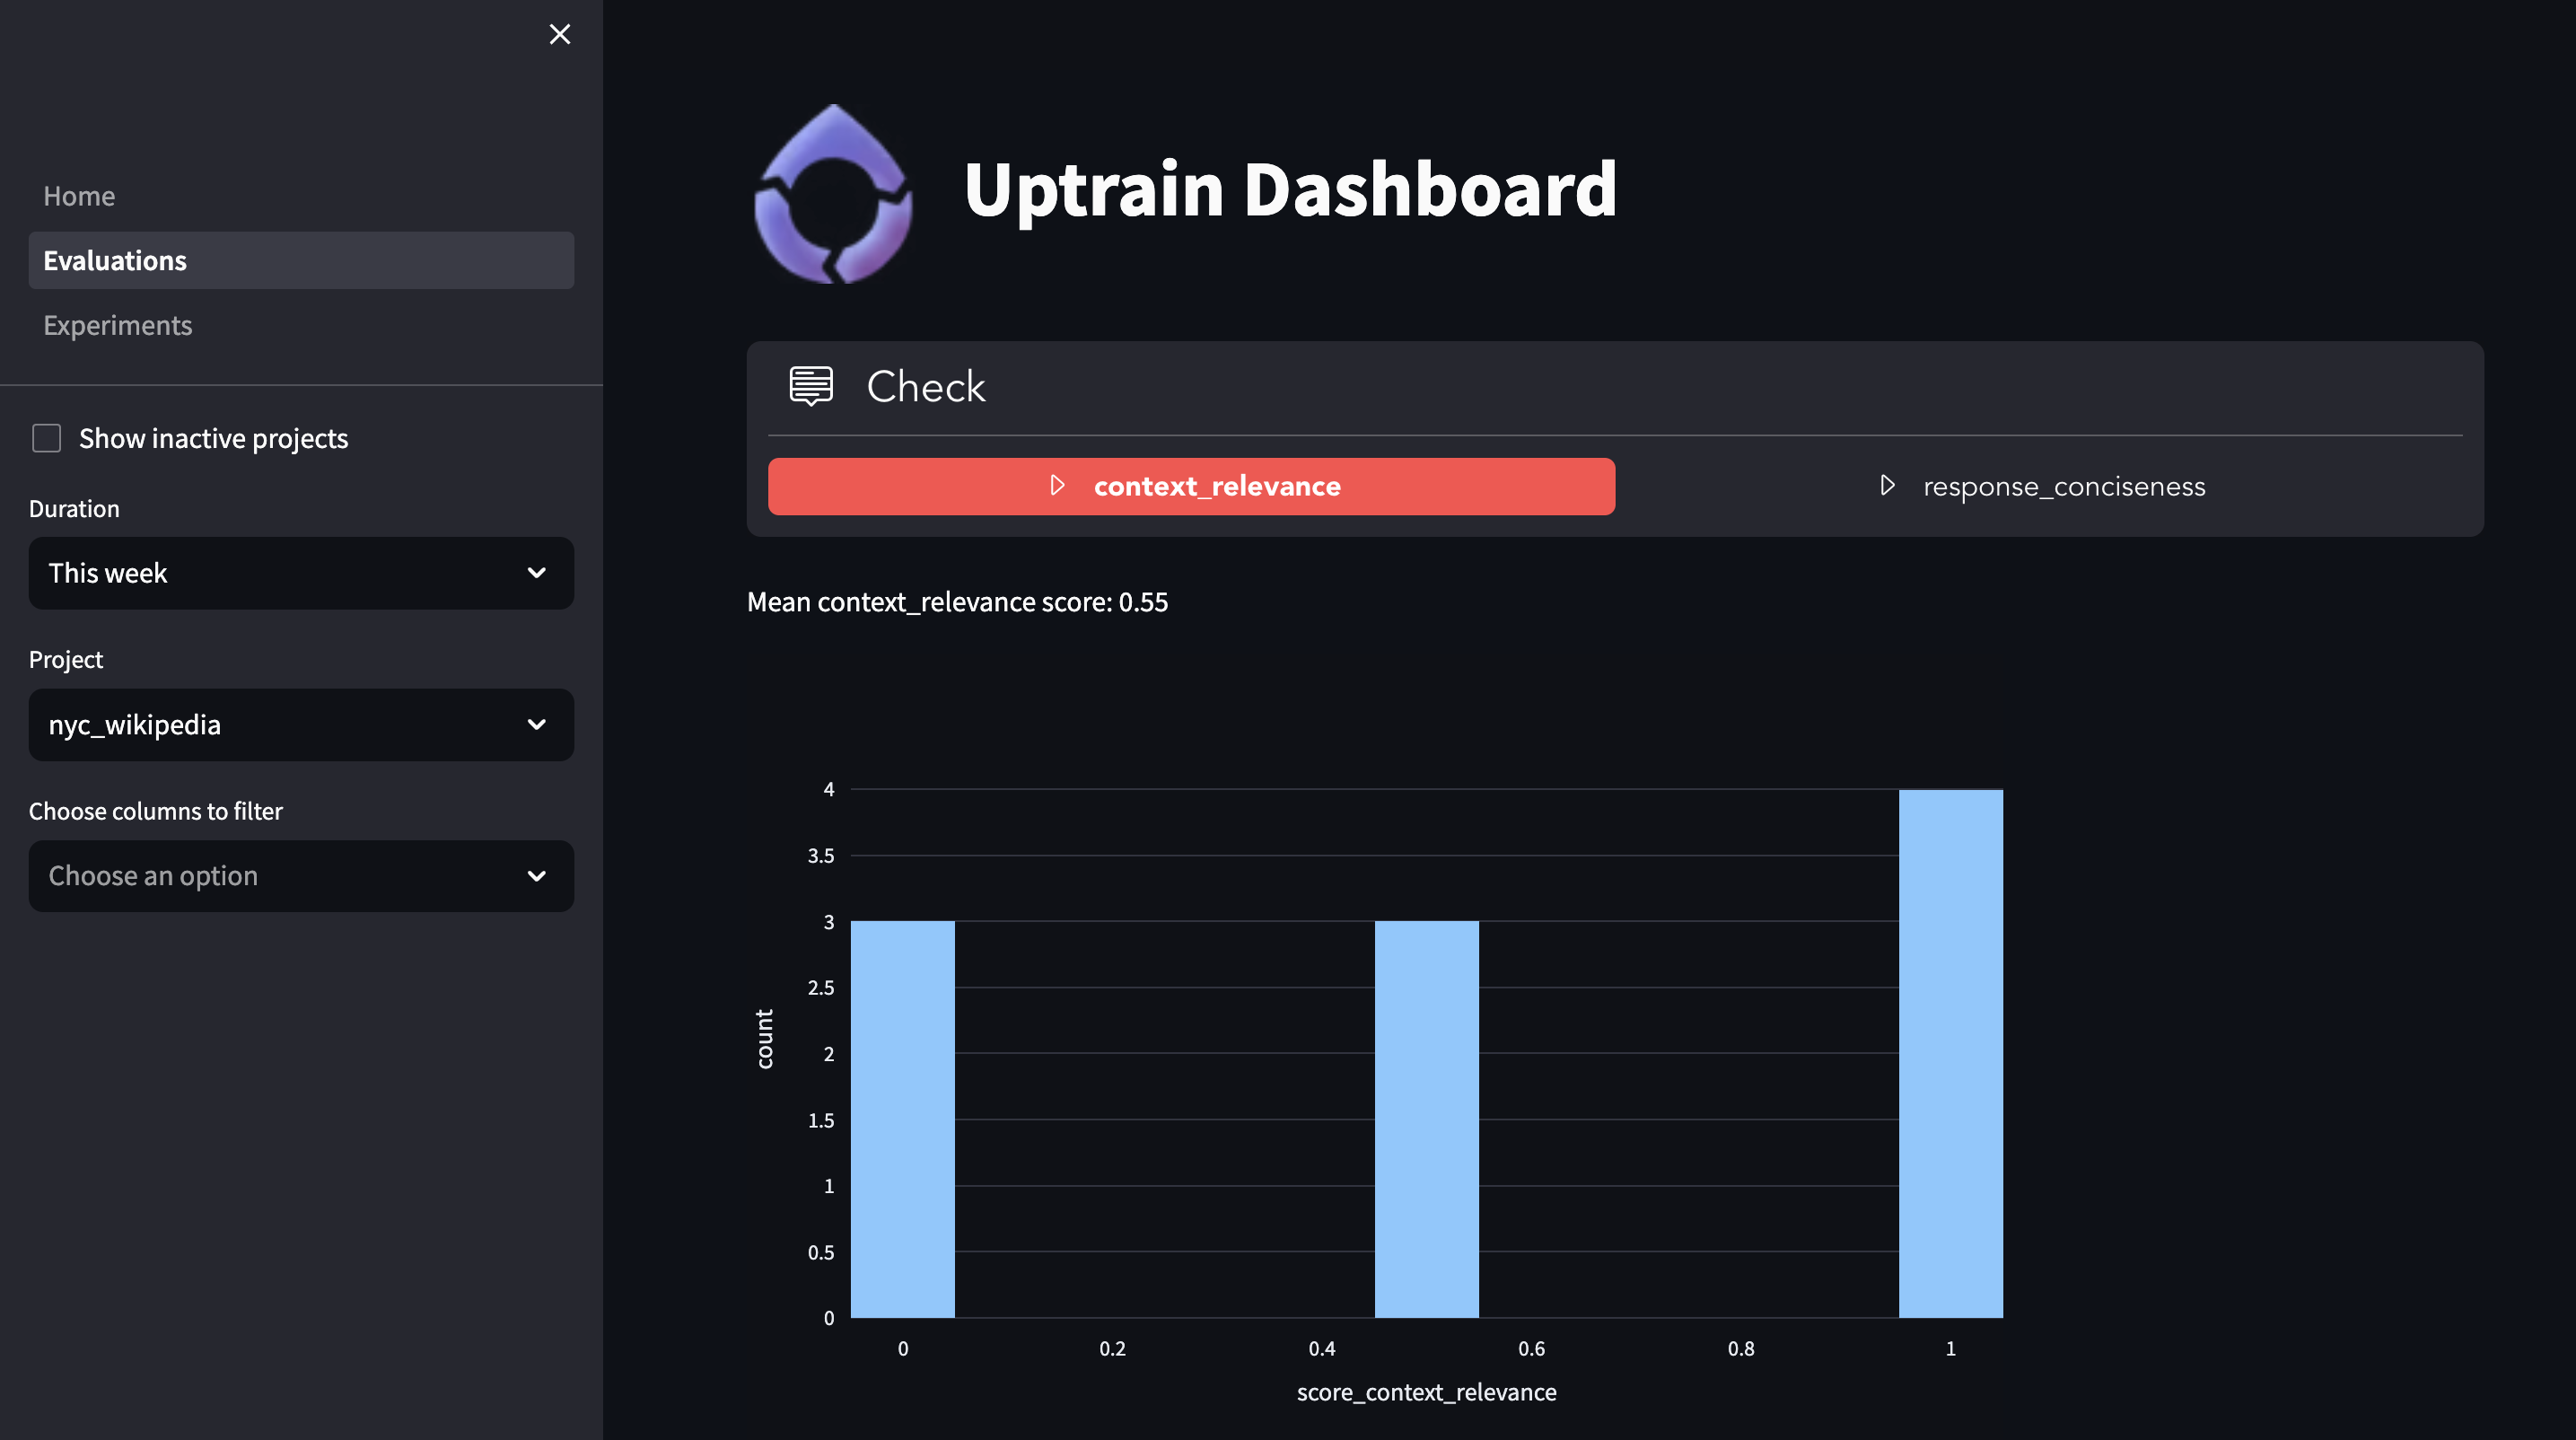

### Insights:
You can filter failure cases and generate common topics among them. This can help identify the core issue and help fix it

![nyc_insights.png](https://uptrain-assets.s3.ap-south-1.amazonaws.com/images/llamaindex/nyc_insights.png)
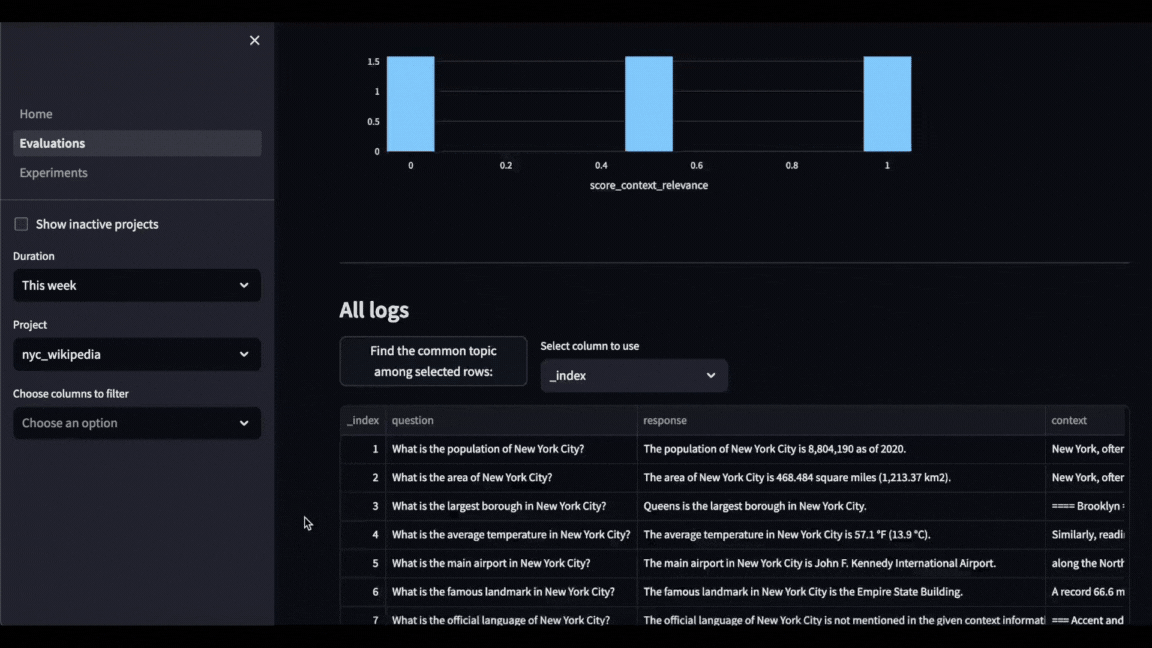